Data set can be found at https://snap.stanford.edu/data/twitch_ego_nets.html

In [11]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import csv
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import copy
import seaborn as sns

## Read the data

In [12]:
file_path = "outputs/all.json"

with open(file_path, "r") as f:
    export_data = json.load(f)

nx_graphs = {}
print(f"Loading {len(export_data)} graphs...")

for gn, data in export_data.items():
    G = nx.Graph()
    G.add_nodes_from(range(1, data["size"] + 1))
    G.add_edges_from(data["edges"])
    
    G.graph["name"] = gn
    G.graph["damks_vlist"] = data["damks_vlist"]
    G.graph["damks_density"] = data["damks_density"]
    
    nx_graphs[gn] = G
    print(f"Successfully reconstructed Graph {gn}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Example: Access the first graph's density
first_key = list(nx_graphs.keys())[0]
print(f"\nExample Density for {first_key}: {nx_graphs[first_key].graph['damks_density']}")

Loading 274 graphs...
Successfully reconstructed Graph 109: 44 nodes, 103 edges
Successfully reconstructed Graph 264: 41 nodes, 85 edges
Successfully reconstructed Graph 1: 40 nodes, 188 edges
Successfully reconstructed Graph 519: 34 nodes, 79 edges
Successfully reconstructed Graph 217: 15 nodes, 47 edges
Successfully reconstructed Graph 334: 25 nodes, 68 edges
Successfully reconstructed Graph 371: 25 nodes, 71 edges
Successfully reconstructed Graph 2: 31 nodes, 69 edges
Successfully reconstructed Graph 65: 21 nodes, 71 edges
Successfully reconstructed Graph 51: 27 nodes, 127 edges
Successfully reconstructed Graph 447: 18 nodes, 69 edges
Successfully reconstructed Graph 335: 39 nodes, 226 edges
Successfully reconstructed Graph 299: 38 nodes, 94 edges
Successfully reconstructed Graph 435: 43 nodes, 164 edges
Successfully reconstructed Graph 489: 35 nodes, 162 edges
Successfully reconstructed Graph 159: 42 nodes, 93 edges
Successfully reconstructed Graph 228: 25 nodes, 62 edges
Successfu

In [ ]:
# get the first graph
G = nx_graphs[first_key]
G.add_nodes_from(range(1, data["size"] + 1))
G.add_edges_from(data["edges"])

# # 4. Prepare Styling
# highlight_nodes = set(data["damks_vlist"])

# # Node Colors: Orange for the dense core, lightgrey for the rest
# node_colors = [
#     "black" if node in highlight_nodes else "lightgrey" 
#     for node in G.nodes()
# ]

# # Edge Colors: Red if both endpoints are in the dense core, black otherwise
# edge_colors = [
#     "black" if (u in highlight_nodes and v in highlight_nodes) else "grey"
#     for u, v in G.edges()
# ]

# # Edge Widths: Thick for core, thin for background
# edge_widths = [
#     1 if (u in highlight_nodes and v in highlight_nodes) else 0.5
#     for u, v in G.edges()
# ]

# # 5. Draw
# plt.figure(figsize=(6, 6))
# pos = nx.spring_layout(G, k=0.15, iterations=20) # Layout for better spacing

# nx.draw(
#     G, pos,
#     node_color=node_colors,
#     edge_color=edge_colors,
#     width=edge_widths,
#     node_size=100,
#     with_labels=False
# )

# plt.title(f"Densest at-most-15 subgraph: (Density: {data['damks_density']:.3f})")
# plt.show()


# Color nodes: black for densest subgraph, white for others
node_colors = ["black" if node in set(data["damks_vlist"]) else "white" for node in G.nodes()]
edgecolors = ["black"] * len(G.nodes())

# Plot
# Color nodes: gray for densest subgraph, white for others
node_colors = ["gray" if node in set(data["damks_vlist"]) else "white" for node in G.nodes()]
edgecolors = ["black"] * len(G.nodes())

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    edgecolors=edgecolors,
    node_size=300,
    linewidths=1.5
)

nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='gray', width=1.0)

nx.draw_networkx_labels(G, pos, font_size=9, font_color='black')

plt.axis("off")
plt.tight_layout()
plt.show()



KeyError: 'damks_vlist'

In [4]:
K = 15

## Utility Functions and Learning-augmented DamkS Algorithm

In [13]:
# Utility functions
def build_adjacency_list(edges):
    """
        Build an adjacency list from a list of edges.
    """
    adj = defaultdict(set)
    for u, v in edges:
        adj[u].add(v)
        adj[v].add(u)
    return {u: list(neighs) for u, neighs in adj.items()}

def compute_degrees_and_avg_neighbor_degrees(adj_list):
    """
        Compute the degree of each node and the average degree of its neighbors.
    """
    degrees = {node: len(neighbors) for node, neighbors in adj_list.items()}

    avg_neighbor_degrees = {}
    for node, neighbors in adj_list.items():
        if neighbors:
            total = sum(degrees.get(neighbor, 0) for neighbor in neighbors)
            avg = total / len(neighbors)
            avg_neighbor_degrees[node] = avg
        else:
            avg_neighbor_degrees[node] = 0.0

    return degrees, avg_neighbor_degrees

def compute_density(edges, S):
    """
        Compute the density of a subgraph S given the edges of the original graph.
    """
    e_s = 0
    for u, v in edges:
        if u in S and v in S:
            e_s += 1
    return e_s / len(S) if S else 0.0


def augment_damks(edges, S, k, epsilon = 0.1):
    """
        Augmented learning algorithm for Densest at-most-k Subgraph (DamkS).
    """
    t = defaultdict(int)
    for u, v in edges:
        if u not in S and v in S:
            t[u] += 1
        if v not in S and u in S:
            t[v] += 1

        
    sorted_nodes = sorted(t.items(), key=lambda x: x[1], reverse=True)    
    num_nodes_to_add = int(len(S) * epsilon / (1 - epsilon)) # Select the top |S|*epsilon/(1-epsilon) nodes
    
    # Step 1: 
    U = [node for node, _ in sorted_nodes[:num_nodes_to_add]]    
    S.update(U) # Add these nodes to S
    
    # Step 2: Trimming step 
    while len(S) > k:
        # Remove node with lowest degree in S
        degS = defaultdict(int)
        for u, v in edges:
            if u in S and v in S:
                degS[u] += 1
                degS[v] += 1
        node_to_remove = min(S, key=lambda x: degS[x])
        S.remove(node_to_remove)
    
    density = compute_density(edges, S)
    return S, density


## Training Models to Predict DamkS 

In [14]:
training_size = int(0.8 * len(nx_graphs))

count = 1
training = dict()
testing = dict()

for gn, G in nx_graphs.items():
    if count <= training_size:
        training[gn] = copy.deepcopy(G)
    else:
        testing[gn] = copy.deepcopy(G)
         
    count += 1

training_fn = "node_features_with_labels_damks.csv"
# Create CSV file and write header
with open(training_fn, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["degree", "avg_neighbor_degree", "number_of_nodes", "is_in_damks"])

for gn, G in training.items():
    adj = build_adjacency_list(G.edges())
    degrees, avg_neighbor_degrees = compute_degrees_and_avg_neighbor_degrees(adj)
    num_nodes = G.number_of_nodes()
    G.graph["degrees"] = degrees
    G.graph["avg_neighbor_degrees"] = avg_neighbor_degrees
    
    with open(training_fn, "a", newline="") as csvfile:
        for node in G.nodes():
            node_degree = degrees[node]
            node_avg_neighbor_degree = avg_neighbor_degrees[node]
            is_in_damks = 1 if node in G.graph["damks_vlist"] else 0
            G.nodes[node]["features"] = (node_degree, node_avg_neighbor_degree, num_nodes)
            G.nodes[node]["label"] = is_in_damks
            writer = csv.writer(csvfile)
            writer.writerow([node_degree, node_avg_neighbor_degree, num_nodes, is_in_damks])
            
   
    

(7638, 3) (7638,)
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       915
           1       0.82      0.85      0.83       613

    accuracy                           0.86      1528
   macro avg       0.86      0.86      0.86      1528
weighted avg       0.86      0.86      0.86      1528



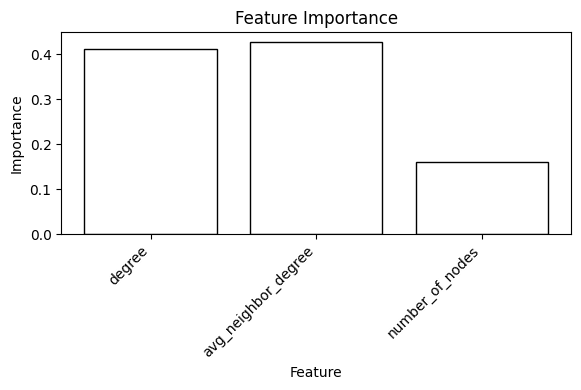

In [15]:
# Load training data from CSV
df = pd.read_csv("node_features_with_labels_damks.csv")
X = df[["degree", "avg_neighbor_degree", "number_of_nodes"]]
y = df["is_in_damks"]

print(X.shape, y.shape)


# Split into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train a Random Forest
clf = RandomForestClassifier(random_state=42, n_estimators=10)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot feature importance
importances = clf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(6, 4))
plt.bar(feature_names, importances, color='white', edgecolor='black')
plt.title("Feature Importance")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Graph: 209, Predicted Density: 3.0909, Augmented Density: 3.4167, Optimal Density: 3.5833
Graph: 185, Predicted Density: 2.2857, Augmented Density: 2.2857, Optimal Density: 2.7143
Graph: 70, Predicted Density: 3.5333, Augmented Density: 4.2000, Optimal Density: 4.6667
Graph: 445, Predicted Density: 5.7826, Augmented Density: 5.7333, Optimal Density: 5.7333
Graph: 431, Predicted Density: 3.7857, Augmented Density: 3.9333, Optimal Density: 4.5714
Graph: 157, Predicted Density: 6.4737, Augmented Density: 6.0667, Optimal Density: 6.0667
Graph: 349, Predicted Density: 3.8500, Augmented Density: 4.0667, Optimal Density: 4.0667
Graph: 520, Predicted Density: 5.3750, Augmented Density: 5.4000, Optimal Density: 5.4000
Graph: 191, Predicted Density: 3.6667, Augmented Density: 3.6000, Optimal Density: 3.6667
Graph: 165, Predicted Density: 4.2381, Augmented Density: 3.8667, Optimal Density: 3.9091
Graph: 304, Predicted Density: 3.0000, Augmented Density: 3.4545, Optimal Density: 4.0000
Graph: 338,

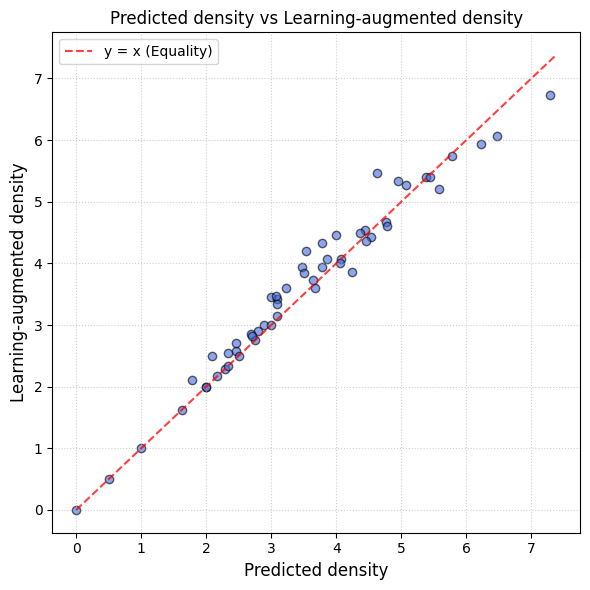

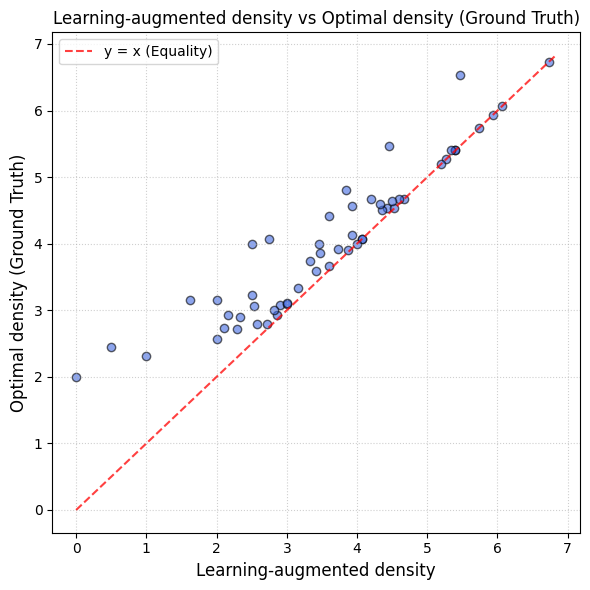

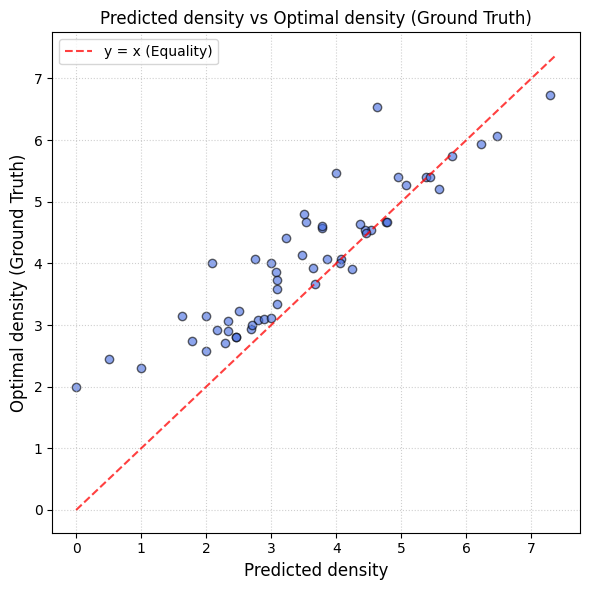

In [16]:
predict, augmented, optimal = [], [], []

for gn, G in testing.items():
    adj = build_adjacency_list(G.edges())
    degrees, avg_neighbor_degrees = compute_degrees_and_avg_neighbor_degrees(adj)
    
    # Extract features and labels for testing
    num_nodes = G.number_of_nodes()
    G.graph["degrees"] = degrees
    G.graph["avg_neighbor_degrees"] = avg_neighbor_degrees
    
    X = pd.DataFrame({
        "degree": [degrees.get(node, 0) for node in G.nodes()],
        "avg_neighbor_degree": [avg_neighbor_degrees.get(node, 0.0) for node in G.nodes()],
        "number_of_nodes": [num_nodes] * num_nodes
    })
    
    y_pred = clf.predict(X)
    S = {node for node, pred in zip(G.nodes(), y_pred) if pred == 1} # Predicted dense subgraph nodes
    
    S_density = compute_density(G.edges(), S)
    S_augmented, S_aug_density = augment_damks(G.edges(), S, K, epsilon=0.1)
    optimal_density = G.graph["damks_density"]
    
    predict.append(S_density)
    augmented.append(S_aug_density)
    optimal.append(optimal_density)
    
    print(f"Graph: {gn}, Predicted Density: {S_density:.4f}, Augmented Density: {S_aug_density:.4f}, Optimal Density: {optimal_density:.4f}")    
    
    

def plot_comparison(x_val, y_val, x_lbl, y_lbl):
    plt.figure(figsize=(6, 6))
    
    plt.scatter(x_val, y_val, alpha=0.6, edgecolor='k', color='royalblue')
    
    # y = x reference line
    lim = max(max(x_val), max(y_val)) + 0.1
    plt.plot([0, lim], [0, lim], 'r--', alpha=0.75, label='y = x (Equality)')
    
    plt.xlabel(x_lbl, fontsize=12)
    plt.ylabel(y_lbl, fontsize=12)
    plt.title(f"{x_lbl} vs {y_lbl}")
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Individual plots
plot_comparison(
    predict, augmented,
    "Predicted density", "Learning-augmented density"
)

plot_comparison(
    augmented, optimal,
    "Learning-augmented density", "Optimal density (Ground Truth)"
)

plot_comparison(
    predict, optimal,
    "Predicted density", "Optimal density (Ground Truth)"
)


# Run the plotting function
#plot_pairwise_comparisons(predict, augmented, optimal)


Approximation Ratio Report (Augmented vs. Optimal):
-----------------------------------------------------
Average Approximation Ratio:  0.8653
Median Approximation Ratio:   0.9462
Worst Case (Min Ratio):       0.0000
Best Case (Max Ratio):        1.0000
-----------------------------------------------------
High Quality Solutions (>= 0.95): 27/55 (49.09%)
-----------------------------------------------------


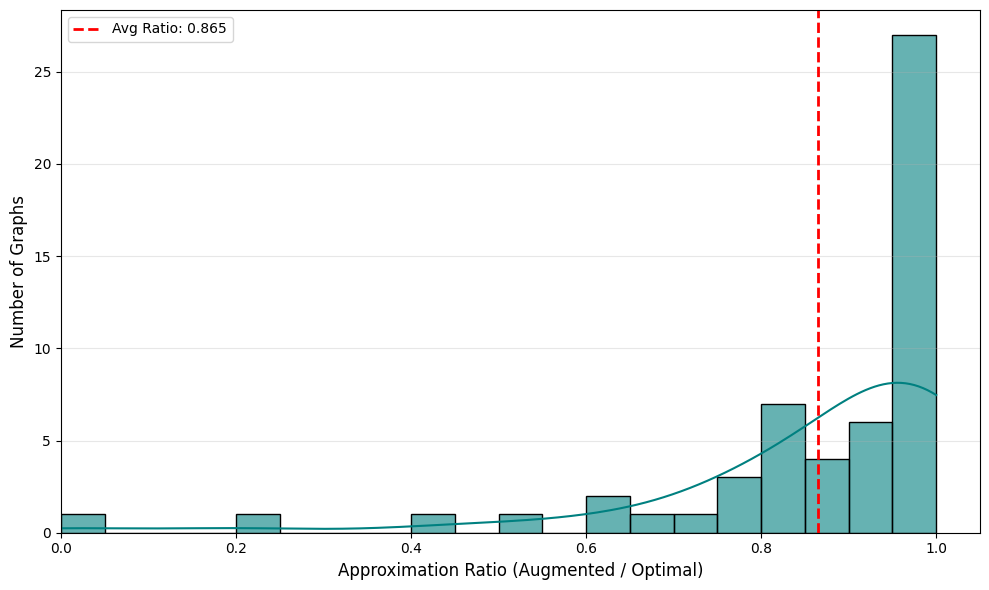

In [17]:


# Compute Approximation Ratio (Augmented / Optimal)
# A ratio of 1.0 means the augmented algorithm found the exact optimal solution
approx_ratios = [
    a / o if o > 0 else 0 
    for a, o in zip(augmented, optimal)
]

# Statistics
avg_ratio = np.mean(approx_ratios)
median_ratio = np.median(approx_ratios)
min_ratio = min(approx_ratios)
max_ratio = max(approx_ratios)

# Count how many achieve > 95% of optimal
high_quality_count = sum(r >= 0.95 for r in approx_ratios)
high_quality_pct = 100 * high_quality_count / len(approx_ratios)

print("Approximation Ratio Report (Augmented vs. Optimal):")
print("-----------------------------------------------------")
print(f"Average Approximation Ratio:  {avg_ratio:.4f}")
print(f"Median Approximation Ratio:   {median_ratio:.4f}")
print(f"Worst Case (Min Ratio):       {min_ratio:.4f}")
print(f"Best Case (Max Ratio):        {max_ratio:.4f}")
print("-----------------------------------------------------")
print(f"High Quality Solutions (>= 0.95): {high_quality_count}/{len(approx_ratios)} ({high_quality_pct:.2f}%)")
print("-----------------------------------------------------")

plt.figure(figsize=(10, 6))

# Plot the distribution
sns.histplot(approx_ratios, kde=True, color='teal', bins=20, alpha=0.6)

# Add a vertical line for the average
plt.axvline(avg_ratio, color='red', linestyle='--', linewidth=2, 
            label=f'Avg Ratio: {avg_ratio:.3f}')

# Add labels and styling
plt.xlabel("Approximation Ratio (Augmented / Optimal)", fontsize=12)
plt.ylabel("Number of Graphs", fontsize=12)
plt.xlim(min(0.5, min_ratio), 1.05) # Ensure we see the spread, up to 1.0
plt.grid(axis='y', alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
print(f"size of testing set: {len(testing)}")
print(f"size of training set: {len(training)}")

size of testing set: 55
size of training set: 219
